### Assignment 1: Discrete event modelling.

**Course:**     Simulation Modeling of Financial and Economic Systems <br>
**Student:**    Danis Alukaev <br>
**Email:**      d.alukaev@innopolis.university <br>
**Group:**      B19-DS-01 <br>

**Variant:**    Task 2 <br>

On average, cars with products arrive at some base each 30 minutes. The average unloading time of one machine is 1.5 hours. Unloading is carried out by two teams of loaders. On the territory of the base, no more than 4 cars can be in line waiting for unloading. Determine the performance of the queuing system.

### Prerequisites

In [1]:
import simpy
import random 
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean

In [2]:
ARRIVAL_PERIOD = 30
UNLOADING_TIME = 90 
LOADERS_NUMBER = 2
QUEUE_LENGTH = 4
UNTIL = 20000
EXPERIMENTS = 100

METRICS = {
    'Queue length': 2.5841182,
    'Number of customers': 4.5051838,
    'Waiting time': 2.0177193,
    'Response time': 3.5177193,
    'Rejected': 0.3596448,
    'Immediately Accepted': 0.0631475,
    'Relative throughput': 0.6403552,
    'Absolute throughput': 1.2807104
}

In [3]:
class Logger:
    """
    The class used to log simulation progress to the file.
    By default, saves logs to directory './logs'.
    """

    def __init__(self, date, logs_dir='./logs'):
        self.logs_dir = logs_dir
        if not os.path.exists(self.logs_dir):
            os.mkdir(self.logs_dir)
        self.filename = f"Session {date}.log"
    
    def write(self, string):
        filepath = os.path.join(self.logs_dir, self.filename)
        with open(filepath, 'a') as f:
            f.write(string + '\n')

### Simulation design

In [4]:
def get_random_interval(mean):
    """
    The method returning the random integer from exponential distribution.
    Rate parameter is derived from the given average time for the action.
    :arg mean: the average time taking the action.
    :return: time interval from exponential distribution.
    """

    intensity = 1 / mean
    interval = int(random.expovariate(intensity))
    return interval

In [5]:
class ProductBase:
    """
    Class representing the products' base involved in the task.
    It aggregates the loader resources and implements the unloading functionality.
    The time required by loaders is taken at random from exponential distribution.
    """

    def __init__(self, env, loader_number, unloading_time, queue_length):
        self.env = env
        self.loader_number = loader_number
        self.loaders = simpy.Resource(env, capacity=loader_number)
        self.unloading_time = unloading_time
        self.queue = []
        self.queue_length = queue_length
    
    def unload(self, car, logger):
        interval = get_random_interval(self.unloading_time)
        yield self.env.timeout(interval)
        # print(f"Car {car.id} was unloaded at {env.now:.2f}.")
        logger.write(f"{self.env.now}: {car.id} unloaded")

In [6]:
class Car:
    """
    Class representing the truck carrying the goods from suppliers.
    Implements arriving mechanism: if the queue is full, the car is rejected 
    by product base. Otherwise, the product base accepts the truck and performs the 
    unloading procedure.  
    """

    def __init__(self, env, id):
        self.env = env
        self.id = id
    
    def arrive(self, product_base: ProductBase, logger: Logger, data: dict):
        data['__All__'] += 1
        if len(product_base.queue) > product_base.queue_length - 1:
            data['Number of customers'].append((self.env.now, product_base.loaders.count + len(product_base.queue)))
            logger.write(f"{self.env.now}: {self.id} rejected")
            data['__Rejected__'] += 1
            data['Rejected'].append((self.env.now, data['__Rejected__'] / data['__All__']))
            # print(f"Car {self.id} was rejected by products base.")
            return
        with product_base.loaders.request() as request:
            time_request, queue_request = self.env.now, len(product_base.queue)
            data['Number of customers'].append((self.env.now, product_base.loaders.count + len(product_base.queue)))
            data['Rejected'].append((self.env.now, data['__Rejected__'] / data['__All__']))

            product_base.queue.append(self.id)
            yield request 
            time_accepted, queue_accepted = self.env.now, len(product_base.queue)
            product_base.queue.remove(self.id)
            data['__Accepted__'] += 1
            data['Relative throughput'].append((self.env.now, data['__Accepted__'] / data['__All__']))
            if time_request != time_accepted:
                data['Queue length'].append((time_request, queue_request))
                data['Queue length'].append((time_accepted, queue_accepted))
            else:
                data['__Immediately accepted__'] += 1
                data['Immediately Accepted'].append((self.env.now, data['__Immediately accepted__'] / data['__All__']))
            data['Waiting time'].append((time_accepted, (time_accepted-time_request)/60))
            data['Rejected'].append((self.env.now, data['__Rejected__'] / data['__All__']))

            logger.write(f"{self.env.now}: {self.id} accepted")
            # print(f"Car {self.id} enters the base at {self.env.now:.2f}.")
            yield self.env.process(product_base.unload(self, logger))
            logger.write(f"{self.env.now}: {self.id} left")
            data['Number of customers'].append((self.env.now, product_base.loaders.count + len(product_base.queue)))
            data['Response time'].append((self.env.now, (self.env.now-time_request)/60))
            data['__Done__'] += 1
            data['Absolute throughput'].append((self.env.now, data['__Done__'] / (self.env.now/60)))
            # print(f"Car {self.id} leaves the base at {self.env.now:.2f}.")

In [7]:
def setup(env, arrival_period, unloading_time, loaders_number, queue_length, logger, data):
    """
    The method used to configure all the classes implemented and start the 
    request flow.
    """

    product_base = ProductBase(env, loaders_number, unloading_time, queue_length)
    cars = []

    while True:
        interval = get_random_interval(arrival_period)
        yield env.timeout(interval)
        cars.append(Car(env, len(cars)+1))
        env.process(cars[-1].arrive(product_base, logger, data))

In [8]:
def simulate():
    data = {
        'Queue length': [],
        'Number of customers': [],
        'Waiting time': [],
        'Response time': [],
        'Rejected': [],
        'Immediately Accepted': [],
        '__Rejected__': 0,
        '__Immediately accepted__': 0,
        '__All__': 0,
        'Relative throughput': [],
        '__Accepted__': 0,
        '__Done__': 0,
        'Absolute throughput': []
    }
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    logger = Logger(timestamp)
    env = simpy.Environment()
    args = (env, ARRIVAL_PERIOD, UNLOADING_TIME, LOADERS_NUMBER, QUEUE_LENGTH, logger, data)
    env.process(setup(*args))
    env.run(until=UNTIL)
    return data

In [9]:
experiments = []
for i in range(EXPERIMENTS):
    experiments.append(simulate())

### Convergence estimation

In [10]:
def prepare(data):
    """
    Method sorting the data for each key in dictionary and expanding 
    the data for each time point.
    """
    new_data = {}
    for k, v in data.items():
        if k[:2] == '__':
            continue
        temp = sorted(list(set(v)), key=lambda x: x[0])
        expanded = []
        for idx in range(len(temp)):
            prev_idx = 0
            if idx != 0:
                prev_idx = temp[idx - 1][0]
            entry = temp[idx]
            expanded += [entry[1]] * (entry[0] - prev_idx)
        left = (UNTIL - temp[-1][0])
        expanded += [temp[-1][1]] * left
        new_data[k] = np.array(expanded)
    return new_data

In [11]:
prepared_experiments = []
for i in range(EXPERIMENTS):
    prepared_experiments.append(prepare(experiments[i]))

In [12]:
def aggregate(data):
    aggregated = {k: [] for k in data[0].keys()}
    for experiment in data:
        for k, v in experiment.items():
            aggregated[k].append(v)
    for k, v in aggregated.items():
        aggregated[k] = np.mean(np.array(v), axis=0)
    return aggregated   

In [13]:
aggregated = aggregate(prepared_experiments)

In [14]:
def visualize(data):
    for k, v in data.items():
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(25, 8)
        fig.suptitle(f"Convergence of {k}")
        ax1.set_title(f"Average value of {k} over time")
        ax1.grid(linestyle='--')
        ax1.set_xlabel('Time, t')
        ax1.set_ylabel(k)
        mean_values = np.array([np.mean(v[:(idx+1)]) for idx in range(len(v))])
        ax1.plot(np.arange(UNTIL), mean_values, '-', label='Emperical', c='b')
        ax1.axhline(y = METRICS[k], color = 'r', label='Analytical', linestyle = '-')
        ax1.legend()

        ax2.set_title("Convergence rate over time")
        ax2.grid(linestyle='--')
        ax2.set_xlabel('Time, t')
        ax2.set_ylabel("Convergence rate")
        shifted = np.roll(mean_values, -1)
        shifted[-1] = shifted[-2]
        convergence_rate = np.absolute(mean_values - shifted)
        ax2.plot(np.arange(UNTIL), convergence_rate, '-', label='Convergence rate', c='b')
        ax2.axhline(y = 0.0001, color = 'r', label='Epsilon', linestyle = '-')
        ax2.legend()

        plt.show() 

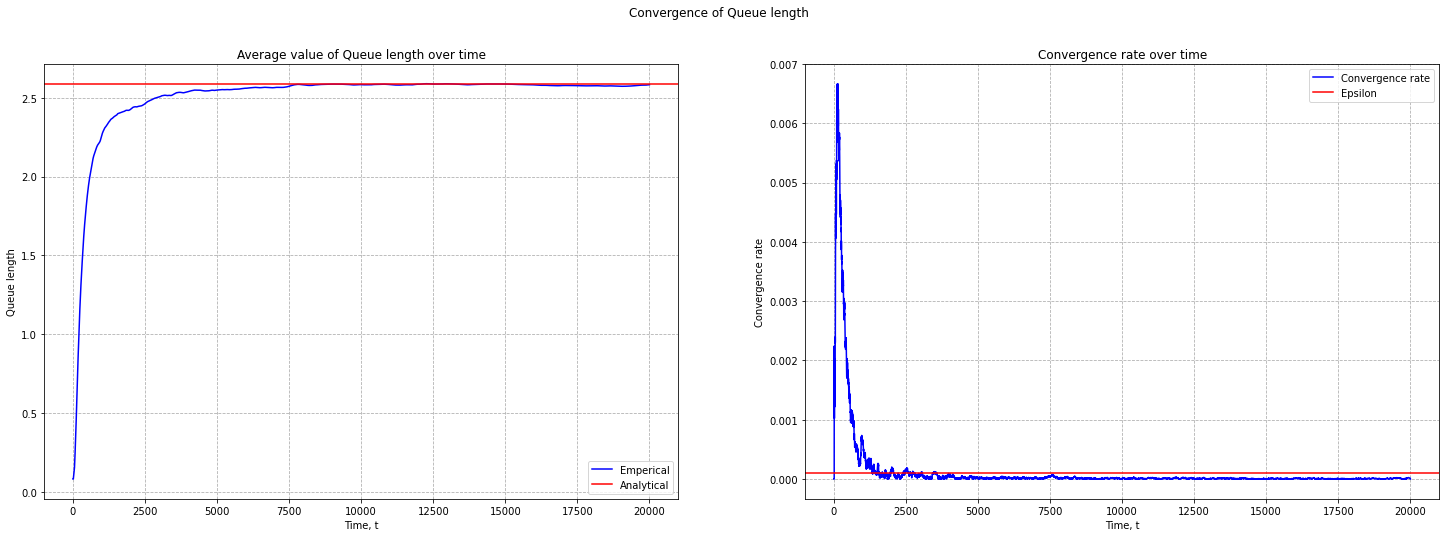

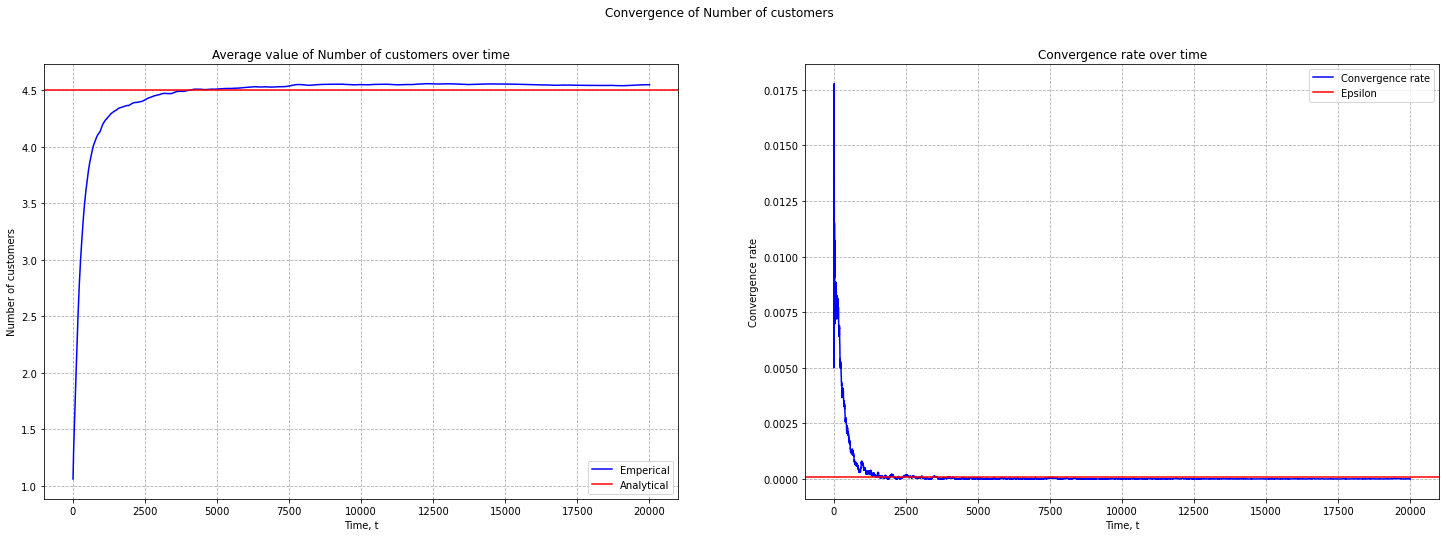

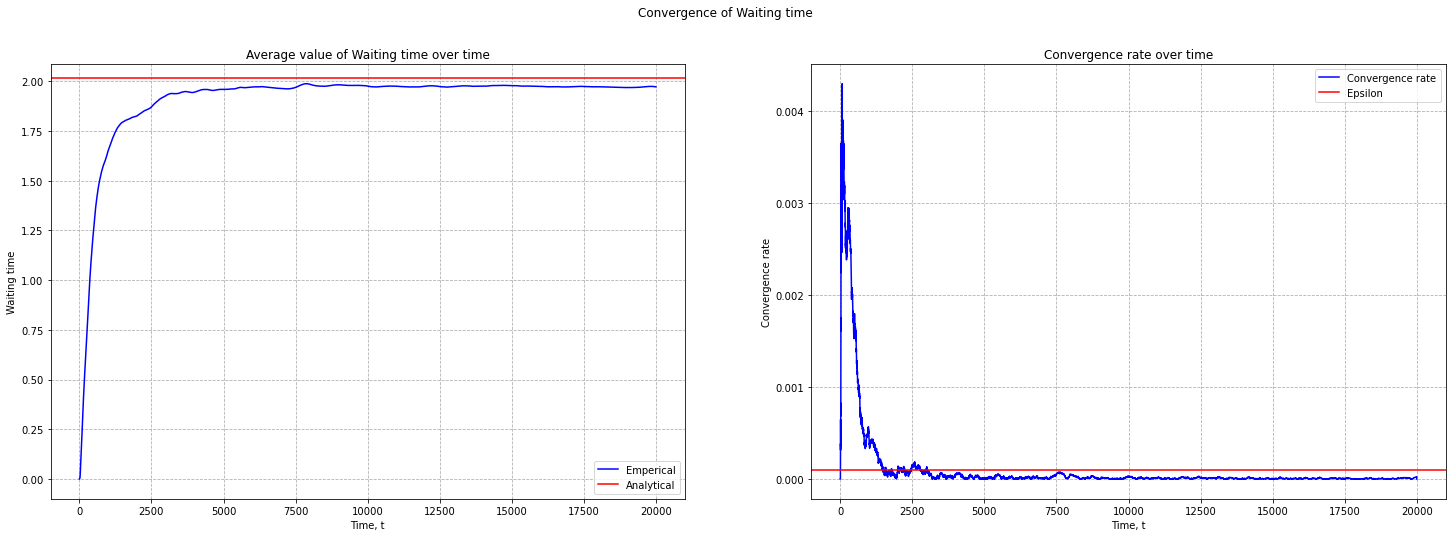

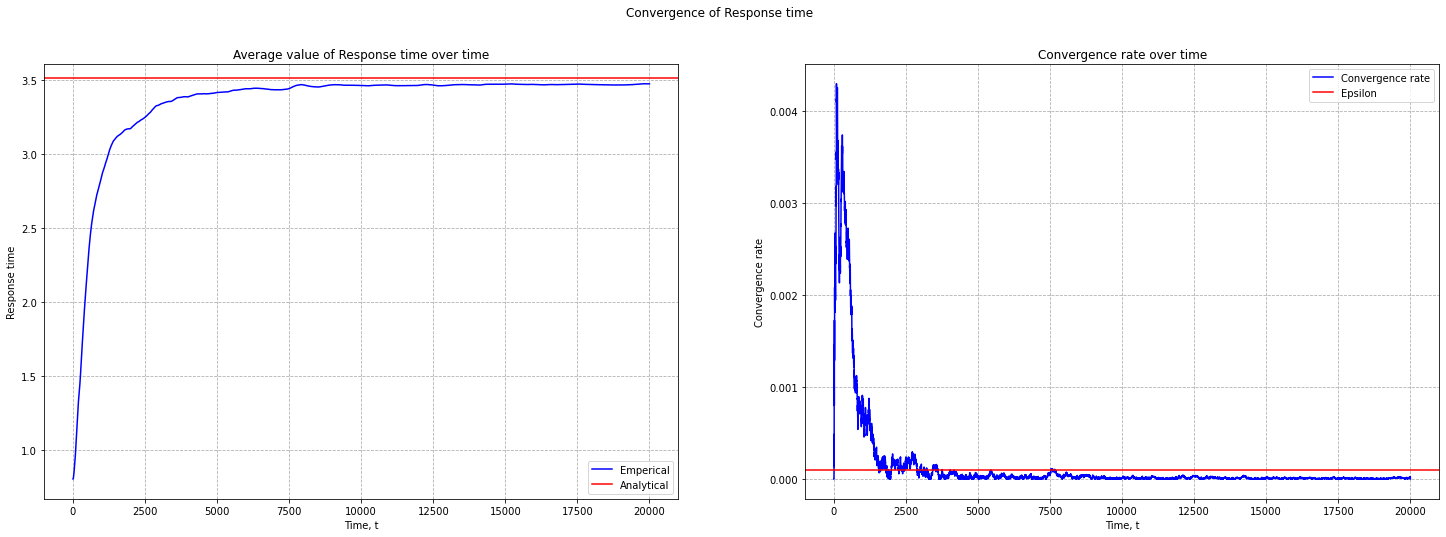

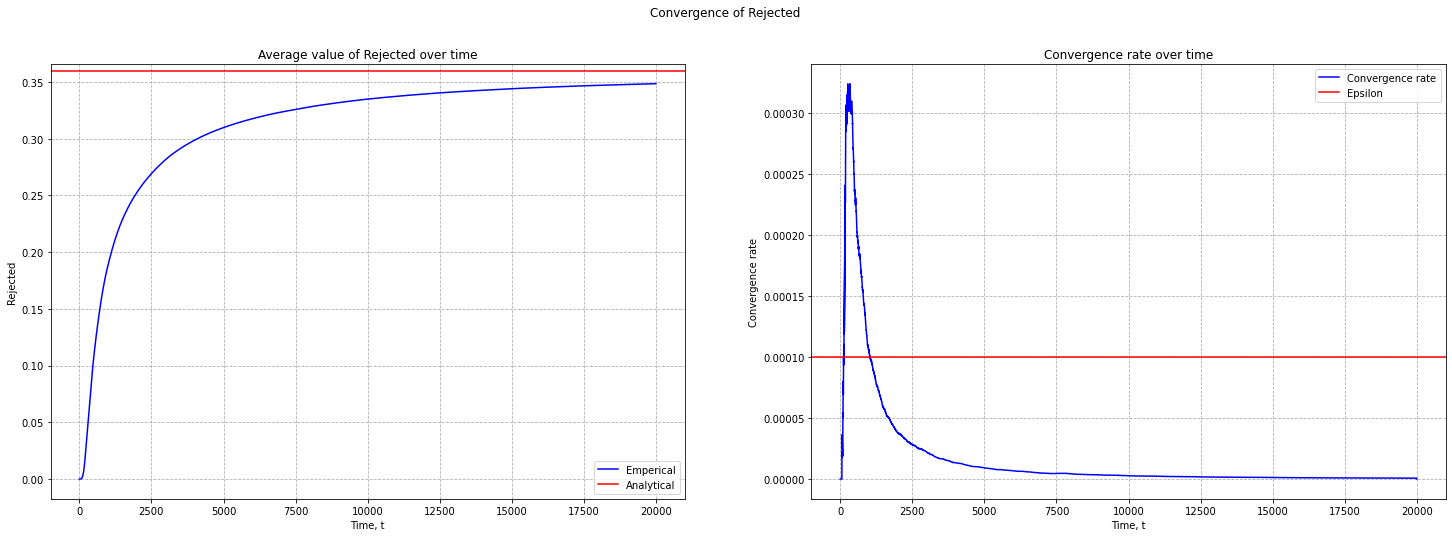

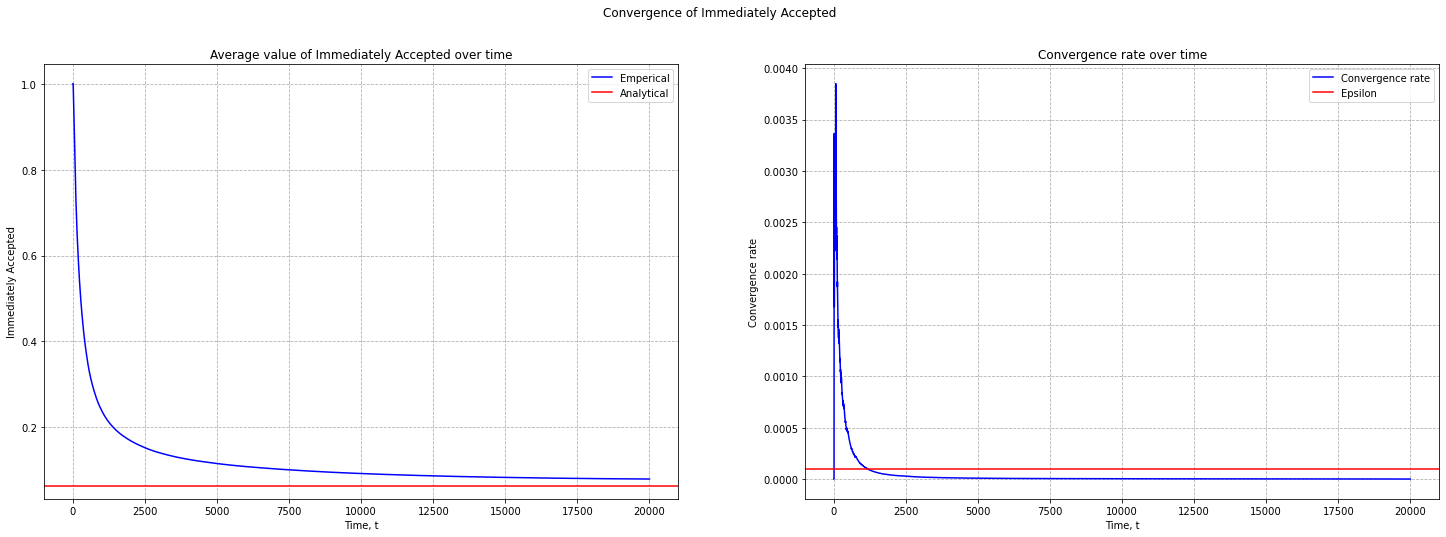

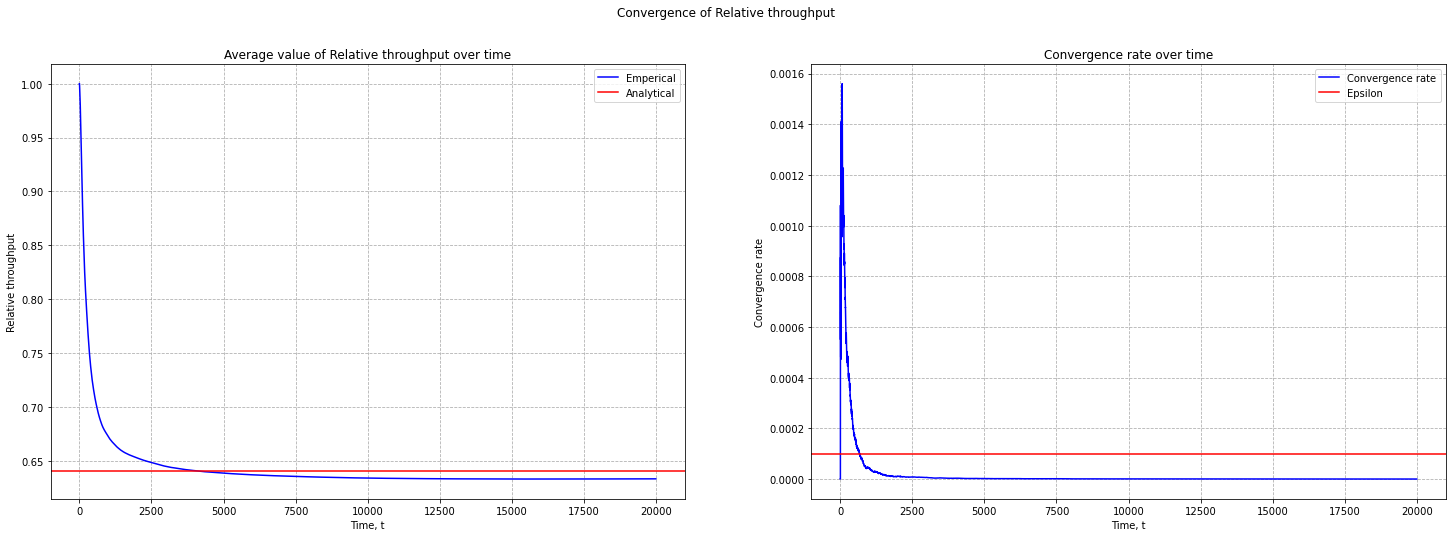

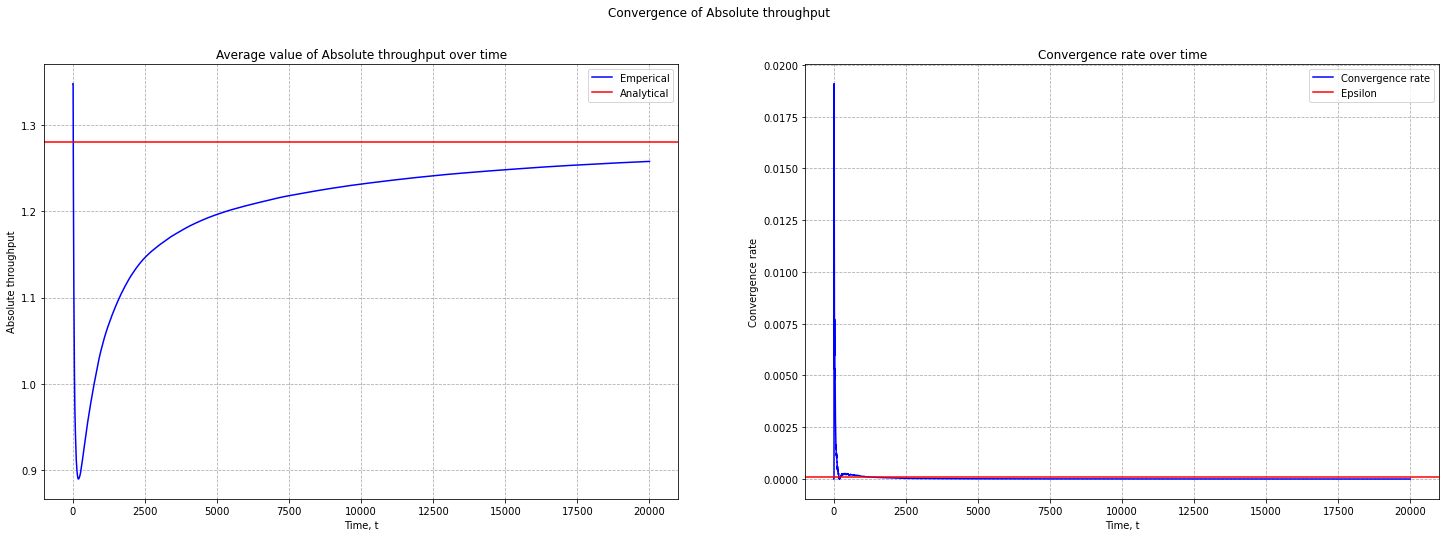

In [15]:
visualize(aggregated)